In [33]:
# This code is thinked as in a experimentation framework

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


############################################

##############################################

def Xy(df,target, coerce=True):
    """
    Split the data in X,y to ML implementations
    """
    if coerce == True:
      X = df.loc[ : , df.columns != target]
      y = df[target].astype('int')
    else:
      X = df.loc[ : , df.columns != target]
      y = df[target]
    return X,y


def specificity_score(y_true, y_pred):
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Extraer los valores de la matriz de confusión
    tn, fp, fn, tp = conf_matrix.ravel()
    # Calcular la especificidad
    specificity = tn / (tn + fp)
    return specificity

In [35]:
URL = "https://raw.githubusercontent.com/it-ces/Datasets/main/basesuper.csv"

In [36]:
df = pd.read_csv(URL)

In [37]:
# Build financial ratios...



url = "https://raw.githubusercontent.com/it-ces/Datasets/main/basesuper.csv"
df = pd.read_csv(url)
features = ['Activos corrientes totales', 'Pasivos corrientes totales' , 'Ganancia bruta', 'Patrimonio total', 'Total pasivos', 'Total de patrimonio y pasivos', 'y']
df = df[features]
df.dropna(inplace=True)
df['razon_corriente'] =  df['Activos corrientes totales'] / df['Pasivos corrientes totales']
df['rentabilidad_patrimonio'] = df['Ganancia bruta'] / df['Patrimonio total']
df['endeudamiento'] = df['Total pasivos'] / df[ 'Total de patrimonio y pasivos']
df['short_run_apalancamiento'] = df['Pasivos corrientes totales'] / df['Patrimonio total']

featuresy = ['razon_corriente',
             'rentabilidad_patrimonio',
             'endeudamiento' ,
             'short_run_apalancamiento' ,'y']
df = df[featuresy]
df.dropna(inplace=True)


import pandas as pd
import numpy as np

def clean(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

df = clean(df)

# Make this
X,y = Xy(df, 'y')

rus = RandomUnderSampler(random_state=1234)
X_res, y_res = rus.fit_resample(X, y)
df  = pd.concat([X_res,y_res], axis=1)
##############
# Split the dataset
#################
df_train, df_test =  train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['y'])
X  = ['razon_corriente', 'rentabilidad_patrimonio', 'endeudamiento',
       'short_run_apalancamiento']
for var in X:
  df_train[var]  = (df_train[var] - df_train[var].mean())/df_train[var].std()
  df_test[var] =  (df_test[var] - df_test[var].mean())/df_test[var].std()

X_train, y_train = df_train[X], df_train['y']
X_test, y_test = df_test[X], df_test['y']

In [38]:
def ModelArchitecture(model, architecture, X):
    for li in range(len(architecture)):
        if architecture[li] ==0: # If appear a zero not add layer...
           pass
        if li == 0:
            model.add(Dense(units = architecture[li], activation='sigmoid', input_shape=(X.shape[1],)))
        else:
            model.add(Dense(units = architecture[li], activation='sigmoid' ))
    return model

In [39]:
# We can uses
# Testing epochs and the crossvalidated f1...
tf.random.set_seed(20)
architecture = (5,5,5,1)
model = Sequential()
model  = ModelArchitecture(model, architecture, X_train)
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs =  [10,  30, 50, 100]
f1s_test, f1s_train  = [] , []
for EPOCHS in epochs:
  model.fit(X_train, y_train, epochs=EPOCHS, batch_size=2, verbose=0)
  preds_test = np.where(model.predict(X_test)>0.5, 1, 0)
  preds_train = np.where(model.predict(X_train)>0.5, 1, 0)
  f1s_train.append(f1_score(y_train, preds_train))
  f1s_test.append(f1_score(y_test, preds_test))
epochs[np.array(f1s_test).argmax()]

9/9 [==============================] - 0s 3ms/step


30

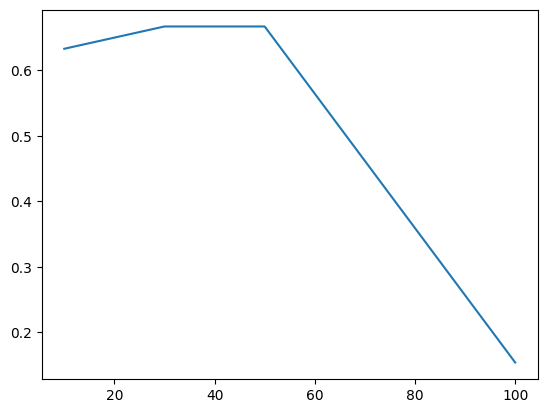

In [40]:
plt.plot(epochs, f1s_test)

In [41]:
def eval_model_NN(classifier,
                  X_train_,
                  y_train_,
                  epochs,
                  k_folds):
    # Take in mind that classifier is classifier
    # model = DecisionTreeClassifier()
    X_train, y_train  = X_train_.copy(), y_train_.copy()
    X_train, y_train = X_train.to_numpy() , y_train.to_numpy()
    evaluations = {'f1':[], 'accuracy':[], 'specificty':[], 'sensitivity-recall':[], 'precision':[]}
    skf = StratifiedKFold(n_splits=k_folds, random_state=123, shuffle=True)
    for itrain, itest in skf.split(X_train, y_train):
        Xi_train, Xi_test = X_train[itrain], X_train[itest]
        yi_train, yi_test = y_train[itrain], y_train[itest]
        classifier.fit(Xi_train,
                       yi_train,
                       epochs=epochs)
        preds = np.where(classifier.predict(Xi_test)>0.5,1,0) # Predictions ->[0,1]
        evaluations['f1'].append(f1_score(yi_test, preds))
        evaluations['accuracy'].append(accuracy_score(yi_test, preds))
        evaluations['specificty'].append(specificity_score(yi_test, preds))
        evaluations['sensitivity-recall'].append(recall_score(yi_test, preds))
        evaluations['precision'].append(precision_score(yi_test, preds))
        #print(len(yi_train), len(Xi_train), len(Xi_test), len(yi_test))
    return evaluations

def mean_results_NN(results, metric):
    return np.array(results[metric]).mean()

In [42]:
errors_mean  = []
architecture = (10,5,5,3,3,2,1)
model = Sequential()
model  = ModelArchitecture(model, architecture, X_train)
model.compile(optimizer="SGD",
              loss='binary_crossentropy',
              metrics=['accuracy'])
EPOCHS  = [25, 100, 350]
for epoch in EPOCHS:
  results = eval_model_NN(classifier  = model,
              X_train_ =  X_train,
              y_train_  = y_train,
              epochs =epoch,
              k_folds= 5)
  errors_mean.append(mean_results_NN(results, 'f1'))

Optimun_epochs  = epochs[np.array(errors_mean).argmax()]

Epoch 1/25
7/7 [==============================] - 1s 3ms/step - loss: 0.7717 - accuracy: 0.5000
Epoch 2/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7672 - accuracy: 0.5000
Epoch 3/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7630 - accuracy: 0.5000
Epoch 4/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7590 - accuracy: 0.5000
Epoch 5/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7554 - accuracy: 0.5000
Epoch 6/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7518 - accuracy: 0.5000
Epoch 7/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7485 - accuracy: 0.5000
Epoch 8/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7453 - accuracy: 0.5000
Epoch 9/25
7/7 [==============================] - 0s 4ms/step - loss: 0.7424 - accuracy: 0.5000
Epoch 10/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7396 - accuracy: 0.5000
Epoch 11/25
7/7 [======================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.7083 - accuracy: 0.5000
Epoch 5/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5000
Epoch 6/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7067 - accuracy: 0.5000
Epoch 7/25
7/7 [==============================] - 0s 4ms/step - loss: 0.7059 - accuracy: 0.5000
Epoch 8/25
7/7 [==============================] - 0s 4ms/step - loss: 0.7052 - accuracy: 0.5000
Epoch 9/25
7/7 [==============================] - 0s 4ms/step - loss: 0.7045 - accuracy: 0.5000
Epoch 10/25
7/7 [==============================] - 0s 4ms/step - loss: 0.7039 - accuracy: 0.5000
Epoch 11/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5000
Epoch 12/25
7/7 [==============================] - 0s 4ms/step - loss: 0.7026 - accuracy: 0.5000
Epoch 13/25
7/7 [==============================] - 0s 3ms/step - loss: 0.7021 - accuracy: 0.5000
Epoch 14/25
7/7 [==============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.5000
Epoch 5/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5000
Epoch 6/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5000
Epoch 7/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5000
Epoch 8/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.5000
Epoch 9/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 10/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.5000
Epoch 11/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6955 - accuracy: 0.5000
Epoch 12/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.5000
Epoch 13/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.5000
Epoch 14/25
7/7 [==============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4978
Epoch 5/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4978
Epoch 6/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4978
Epoch 7/25
7/7 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4978
Epoch 8/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.4978
Epoch 9/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4978
Epoch 10/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4978
Epoch 11/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4978
Epoch 12/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4978
Epoch 13/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6938 - accuracy: 0.4978
Epoch 14/25
7/7 [==============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 5/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 6/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 7/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 8/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 9/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 10/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 11/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 12/25
7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5022
Epoch 13/25
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 14/25
7/7 [==============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 12/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 13/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 14/100
7/7 [====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4640
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4550
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4459
Epoch 11/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4640
Epoch 13/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 14/100
7/7 [====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4574
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4709
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4753
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4933
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4843
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4484
Epoch 11/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4574
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5022
Epoch 13/100
7/7 [=====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/350
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/350
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 11/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 12/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 13/350
7/7 [=====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4550
Epoch 3/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 5/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 6/350
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/350
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/350
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4640
Epoch 9/350
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4550
Epoch 10/350
7/7 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4459
Epoch 11/350
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 12/350
7/7 [======================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 4/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 5/350
7/7 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 6/350
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4640
Epoch 7/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4369
Epoch 8/350
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4640
Epoch 9/350
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 10/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4550
Epoch 11/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4730
Epoch 12/350
7/7 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4640
Epoch 13/350
7/7 [=====================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
errors_mean

[0.0, 0.19231337767923132, 0.26504065040650404]

In [44]:
Optimun_epochs

50